# Importando Bibliotecas

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



import numpy as np
import scipy.stats as stats



sns.set(style="dark")




import warnings
warnings.filterwarnings("ignore")

# Importando Dados

In [77]:
#Informações de óbitos decorrente de Diabetes Mellitus - DATASUS
data = {
    'Ano': ['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021'],
    'Óbitos': [56761, 58017, 57882, 59641, 61398, 63486, 65113, 66711, 75712, 78258]
}






In [78]:
# Importando Dados

POP_df  = pd.read_csv('POP.csv') #Dados Populacionais (Pegos no SidraR)
DM_OB   = pd.DataFrame(data) #Dados de Obitos decorrentes de Diabetes Mellitus
DM_df   = pd.read_csv("Diabetes-prediction.csv") #Conjunto de Dados Clínicos
DALYs   = pd.read_csv('IHME-GBD_2019_DATA-ab9b06cb-1.csv') #DALYs

In [79]:
DALYs.head()

,measure_id,measure_name,location_id,location_name,sex_id,sex_name,age_id,age_name,cause_id,cause_name,metric_id,metric_name,year,val,upper,lower
0,1,Deaths,135,Brazil,3,Both,22,All ages,587,Diabetes mellitus,1,Number,2009,48937.304912,51157.864811,45179.980874
1,1,Deaths,135,Brazil,3,Both,22,All ages,587,Diabetes mellitus,2,Percent,2009,0.040865,0.042681,0.037707
2,1,Deaths,135,Brazil,3,Both,22,All ages,587,Diabetes mellitus,3,Rate,2009,24.965620,26.098450,23.048802
3,1,Deaths,135,Brazil,3,Both,22,All ages,587,Diabetes mellitus,1,Number,2010,50717.656136,53060.352381,46557.799562
4,1,Deaths,135,Brazil,3,Both,22,All ages,587,Diabetes mellitus,2,Percent,2010,0.041501,0.043401,0.038269


In [80]:
# Dados do impacto da Diabetes na saúde brasileira

DALYs = DALYs[DALYs['measure_id'] == 2]


DALYs = DALYs.drop(columns=DALYs.columns[0:11])
DALYs['val'] = DALYs.apply(lambda row: f"{row['val']:.2f}" if row['metric_name'] in ['Rate'] else f"{row['val']:.2}" if row['metric_name'] == 'Percent' else int(row['val']), axis=1)
DALYs['upper'] = DALYs.apply(lambda row: f"{row['upper']:.2f}" if row['metric_name'] in ['Rate'] else f"{row['upper']:.2}" if row['metric_name'] == 'Percent' else int(row['upper']), axis=1)
DALYs['lower'] = DALYs.apply(lambda row: f"{row['lower']:.2f}" if row['metric_name'] in ['Rate'] else f"{row['lower']:.2}" if row['metric_name'] == 'Percent' else int(row['lower']), axis=1)






# Tratando Dados

In [81]:
# Tratando os dados populacionais

POP_df.drop(columns=['Unnamed: 0', 'Nível Territorial (Código)', 'Unidade de Medida (Código)', 'Brasil (Código)', 'Brasil', 'Variável (Código)', 'Trimestre Móvel (Código)' ], inplace=True)
POP_df["Ano"] = POP_df['Trimestre Móvel'].apply(lambda x: x.split()[-1])
POP_df.drop(columns='Trimestre Móvel', inplace=True)

In [82]:
# Dados Clínicos

#Excluindo coluna sem dados

DM_df.drop(columns='Unnamed: 0', inplace=True)


# Criação de Faixa Etária e Graus de Obesidade
faixas_etarias = [0, 10, 20, 30, 40, 50, 60, 70, 80]
grau_obesidade = [0, 18.50, 25, 30, 35, 40, 99]
mapeamento_obesidade_n = {'0.0-18.5':-1, '18.5-25.0':0, '25.0-30.0':1, '30.0-35.0':2, '35.0-40.0':3, '40.0-99.0':4}
mapeamento_obesidade_str = {'0.0-18.5':'underweight', '18.5-25.0':'normal', '25.0-30.0':'overweight', '30.0-35.0':'obese_I', '35.0-40.0':'obese_II', '40.0-99.0':'obese_III'}


DM_df['grau_obesidade'] = pd.cut(DM_df['bmi'], bins=grau_obesidade)
DM_df['faixa_etaria']   = pd.cut(DM_df['age'], bins=faixas_etarias)
DM_df['faixa_etaria']   = DM_df['faixa_etaria'].astype(str).str.replace('(', '').str.replace(']', '').str.replace(',', '-').str.replace(' ', '')
DM_df['grau_obesidade'] = DM_df['grau_obesidade'].astype(str).str.replace('(', '').str.replace(']', '').str.replace(',', '-').str.replace(' ', '')
DM_df['grau_obesidade_class'] = DM_df['grau_obesidade'].replace(mapeamento_obesidade_str)
DM_df['grau_obesidade'] = DM_df['grau_obesidade'].replace(mapeamento_obesidade_n)


In [83]:
#DALYs - Transformando notação científica em notação decimal

DALYs_numbers        = DALYs[DALYs['metric_name'] == 'Number'].groupby('year')[['val']].sum()
DALYs_numbers['val'] = DALYs_numbers['val'].apply(lambda x: int(x))
DALYs_numbers['%']   = DALYs_numbers.pct_change()
DALYs_numbers.fillna(0, inplace=True)


DALYs_percent        = DALYs[DALYs['metric_name'] == 'Percent'].groupby('year')[['val']].sum()
DALYs_percent['val'] = DALYs_percent['val'].apply(lambda x: float(x))
DALYs_percent['%']   = DALYs_percent.pct_change()
DALYs_percent.fillna(0, inplace=True)


DALYs_rate         = DALYs[DALYs['metric_name'] == 'Rate'].groupby('year')[['val']].sum() #DALYs razão a cada 100k
DALYs_rate['val']  = DALYs_rate['val'].apply(lambda x: float(x))
DALYs_rate['%']    = DALYs_rate.pct_change()
DALYs_rate.fillna(0, inplace=True)


# Introdução

A presente análise versará sobre a Diabetes e seus fatores de risco, estudando os dados colhidos de base de dados públicas como IBGE (Sidra), DataSUS e IHME (The Institute for Health Metrics and Evaluation).

## O que é Diabetes?

Segundo o Ministério da Saúde brasileiro:

            "É uma doença causada pela produção insuficiente ou má absorção de insulina, hormônio que regula a glicose no sangue e garante energia para o organismo. A insulina é um hormônio que tem a função de quebrar as moléculas de glicose(açúcar) transformando-a em energia para manutenção das células do nosso organismo. O diabetes pode causar o aumento da glicemia e as altas taxas podem levar a complicações no coração, nas artérias, nos olhos, nos rins e nos nervos. Em casos mais graves, o diabetes pode levar à morte."

A Diabetes Mellitus é uma doença crônica não transmissível (DCNT) e segundo a Organização Mundial da Saúde (OMS) faz parte do grupo (DCNT) que são um dos principais problemas de saúde pública do mundo. 
Ainda Segundo a OMS, as DCNT foram responsáveis por, aproximadadmente, 70% dos óbitos ocorridos no mundo em 2019 (WHO, 2021).

A Diabetes é uma das 10 causas principais de carga global quando análisado os DALYs.

Algumas notícias mostra o impacto prático na vida das pessoas com diabetes, como por exemplo:

[Brasil bate recorde de amputações de pés e pernas em decorrência do diabetes](https://sbacv.org.br/brasil-bate-recorde-de-amputacoes-de-pes-e-pernas-em-decorrencia-do-diabetes/)


Ainda citando um trecho da matéria acima:

            "Gravidade – Outro dado preocupante apontado pela SBACV é o desconhecimento dos indivíduos sobre seu estado de saúde. Os especialistas afirmam que milhares de brasileiros têm diabetes e não sabem. “No mundo, uma em cada cinco pessoas ignora ser portador dessa doença. Muitos pacientes que chegam ao consultório ou aos serviços de urgência com complicações do diabetes só descobrem que a têm após o atendimento”, comenta o cirurgião vascular Mateus Borges, diretor de Publicações da SBACV."   

Por tais motivos o tema fora escolhido para análise pelo grupo. Tendo como intuito levar conhecimento à população, a fim de ajudar no combate contra Diabetes e em sua prevenção.


# Análise exploratória de dados.

## Conjunto de Dados Clínicos

O primeiro dado a ser analisado será o IMC - Índice de Massa Corporal.

Pois segundos pesquisadores:

* Os pacientes obesos apresentam elevado risco de desenvolver DMT2 e supõe-se que aproximadamente** 45% dos pacientes com DMT2 apresentam o índice de massa corporal (IMC > 30 kg/m2)**.

- **Diabetes e Hipertensão ocorrem 2,9 vezes mais em indivíduos obesos.**

Em segundo será análisado será a idade pois segundo pesquisadores:

* O diabetes tipo 2 em idosos aparentemente ocorre devido a vários mecanismos, entre os quais podemos citar predisposição genética, **expectativa de vida longa levando a uma diminuição na secreção de insulina** e a modificação de alguns fatores ambientais responsáveis pela obesidade central. **Este último é responsável pela resistência à insulina, que é a principal causa da síndrome metabólica e do diabetes tipo 2 em adultos e idosos.**



![Fatores de Risco](https://github.com/iathon/iathon/blob/dc7bb02425edb659454d20e8d81cc6317daa7035/DS_DA/data/Raphael/img/FRisco_DM2.png)




In [84]:
# Conjunto de Dados Clínicos

ind_dia = DM_df[DM_df['diabetes'] == 1]['age'].count()

display(DM_df.head())
print('='*155)
print('='*155)
print(DM_df.describe())
print('='*155)
print(f'Numéro de indivíduos com e sem diabetes presentes no Dataset: \n{DM_df.diabetes.value_counts()}')
print('='*155)
print(f'O numéro de indivíduos com diabetes presentes no Dataset representa: {round((ind_dia/DM_df.shape[0])*100, 2)}%')
print('='*155)
print(f'Numéro de indivíduos com e sem diabetes presentes no Dataset: \n{DM_df.gender.value_counts()}')
print('='*155)


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,grau_obesidade,faixa_etaria,grau_obesidade_class
0,Female,80.0,0,1,never,25.19,6.6,140,0,1,70-80,overweight
1,Female,54.0,0,0,No Info,27.32,6.6,80,0,1,50-60,overweight
2,Male,28.0,0,0,never,27.32,5.7,158,0,1,20-30,overweight
3,Female,36.0,0,0,current,23.45,5.0,155,0,0,30-40,normal
4,Male,76.0,1,1,current,20.14,4.8,155,0,0,70-80,normal


                 age  hypertension  heart_disease            bmi  \
count  100000.000000  100000.00000  100000.000000  100000.000000   
mean       41.885856       0.07485       0.039420      27.320767   
std        22.516840       0.26315       0.194593       6.636783   
min         0.080000       0.00000       0.000000      10.010000   
25%        24.000000       0.00000       0.000000      23.630000   
50%        43.000000       0.00000       0.000000      27.320000   
75%        60.000000       0.00000       0.000000      29.580000   
max        80.000000       1.00000       1.000000      95.690000   

         HbA1c_level  blood_glucose_level       diabetes  grau_obesidade  
count  100000.000000        100000.000000  100000.000000   100000.000000  
mean        5.527507           138.058060       0.085000        0.995090  
std         1.070672            40.708136       0.278883        1.162411  
min         3.500000            80.000000       0.000000       -1.000000  
25%         

A *prima ictu oculi*, percebemos que há uma grande diferença entre os indivíduos catalogados no Dataset que são acometidos pela Diabetes Mellitus. Como exposto supra, apenas 8,5% dos indivíduos de um Dataset de 100.000 pessoas. Portanto, esse número será filtrado os dados de pessoas não diabéticas será reduzido e selecionadas de forma ramdômica. 

Isso será feito apenas com o intuito de criarmos gráficos que não sejam desagradáveis aos olhos.

Como será exposto logo abaixo, não há tamanha diferença que impacte nas análises gráficas. 

In [85]:
#Quantis

bmi_08q = DM_df.bmi.quantile(.05)
bmi_99q = DM_df.bmi.quantile(.999)
DM_df = DM_df.query('bmi < @bmi_99q & bmi > @bmi_08q')

In [86]:
#Dataframe Filtrado

DM_F = DM_df.query('gender == "Female"').sample(41430, random_state=0)
DM_M = DM_df.query('gender == "Male"')


DM_MF_equal = pd.concat([DM_F, DM_M])



DM_0 = DM_MF_equal.query('diabetes == 0').sample(8500, random_state=0)
DM_1 = DM_MF_equal.query('diabetes == 1')


DM_filtrado = pd.concat([DM_0, DM_1])
DM_filtrado.head()


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,grau_obesidade,faixa_etaria,grau_obesidade_class
85726,Male,20.0,0,0,never,24.02,4.0,200,0,0,10-20,normal
12853,Male,57.0,0,0,not current,44.17,6.0,145,0,4,50-60,obese_III
50232,Female,31.0,0,0,never,39.89,6.6,160,0,3,30-40,obese_II
52683,Female,45.0,0,0,never,26.70,4.5,159,0,1,40-50,overweight
37980,Female,47.0,0,0,never,27.32,6.5,155,0,1,40-50,overweight


In [87]:
DM_0.mean()

age                     41.904456
hypertension             0.064471
heart_disease            0.033529
bmi                     27.510285
HbA1c_level              5.393976
blood_glucose_level    132.477294
diabetes                 0.000000
grau_obesidade           1.027765
dtype: float64

In [88]:
DM_df.query('diabetes == 0').mean()

age                     41.993594
hypertension             0.062108
heart_disease            0.030759
bmi                     27.518319
HbA1c_level              5.396626
blood_glucose_level    132.863360
diabetes                 0.000000
grau_obesidade           1.028526
dtype: float64

In [89]:
DM_1.mean()

age                     61.022749
hypertension             0.241656
heart_disease            0.154339
bmi                     31.803170
HbA1c_level              6.933551
blood_glucose_level    194.265087
diabetes                 1.000000
grau_obesidade           1.788040
dtype: float64

Podemos observar que não há uma diferença muito grande entre as médias dos dados completos de pessoas sem diabetes para os dados filtrados de pessoas sem diabetes. Como não há diferença, os dados filtrados serão usados no decorrer da análise.

## BMI (IMC - Índice de Massa Corporal)

![Imagem Obesidade](https://github.com/iathon/iathon/blob/dc7bb02425edb659454d20e8d81cc6317daa7035/DS_DA/data/Raphael/img/imc2.png)

Podemos perceber que há dados de pacientes com o IMC superior 90, usando calculos básicos uma pessoa com o IMC de 95, como é o caso do paciente presente no dataset, somente seu peso já poria em risco sua vida. Vejamos os exemplos:

    * IMC de 95 com altura de 1,70 metros:
        Peso: Aproximadamente 413 kg

    * IMC de 95 com altura de 1,80 metros:
        Peso: Aproximadamente 491 kg

    * IMC de 95 com altura de 1,90 metros:
        Peso: Aproximadamente 573 kg

Portanto, serão usados apenas 99,90% dos dados, ou seja, serão cortados os dados acima do 99º percentil da coluna BMI, ficando apenas com dados abaixo de 60,83 de BMI.

A Obesidade, como fator de risco das doenças crônicas como a Diabetes Mellitus, é assunto de pautas de saúde pela OMS desde 2004, como podemos ver abaixo:
   
   
            "A Estratégia Global em Alimentação, Atividade Física e Saúde, aprovada em 2004 pela Assembléia Mundial da Saúde, com o firme apoio do governo brasileiro, chama a atenção para o aumento explosivo da obesidade e sobre o impacto desse aumento na incidência de várias doenças crônicas (como diabetes, doenças do coração e certos tipos de câncer), na expectativa de vida da população e nos custos dos serviços de saúde. A Estratégia Global em Alimentação, Atividade Física e Saúde deixa claro que o enfrentamento consequente do problema pelos governos nacionais requer políticas públicas e ações intersetoriais que vão além de informar e educar os indivíduos.Tais políticas devem, essencialmente, propiciar um ambiente que estimule, apoie e proteja padrões saudáveis de alimentação e de atividade física. Por exemplo, por meio de medidas fiscais que tornem mais acessíveis os alimentos saudáveis, de normas que limitem a publicidade de alimentos não saudáveis e de intervenções no planejamento urbano que facilitem a prática cotidiana de atividade física (WORLD HEALTH ORGANIZATION, 2004)."

Type 2 diabetes traz a seguinte colocação sobre a obesidade:

            "Um importante fator de predisposição para o desenvolvimento da diabetes tipo 2 é a obesidade"



!['evol'](img\Evol_fr.png)

# Análise Estatística Descritiva dos dados

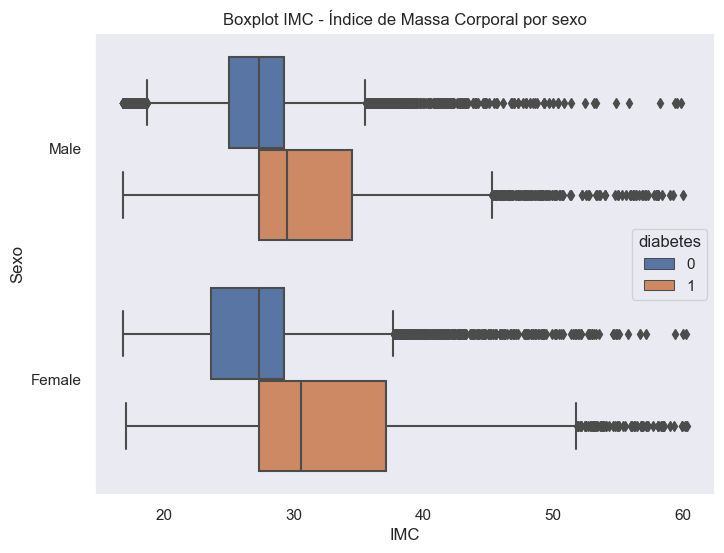

In [90]:
#Gráfico de caixa de avaliação de dados

plt.figure(figsize=(8,6))
sns.boxplot(data=DM_filtrado, x='bmi', y='gender', orient='h', hue='diabetes')
plt.title('Boxplot IMC - Índice de Massa Corporal por sexo')
plt.ylabel('Sexo')
plt.xlabel('IMC')
plt.show()

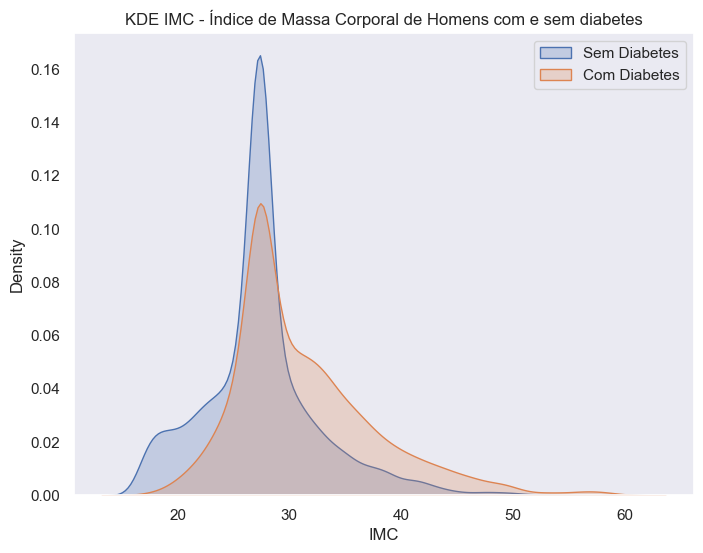

In [91]:
#Gráfico de Densidade de Índice de Massa Corporal de Homens com e sem diabetes

plt.figure(figsize=(8,6))
sns.kdeplot(data=DM_filtrado.query('gender == "Male" & diabetes == 0'), x='bmi', shade=True, label='Sem Diabetes')
sns.kdeplot(data=DM_filtrado.query('gender == "Male" & diabetes == 1'), x='bmi', shade=True, label='Com Diabetes')
plt.title('KDE IMC - Índice de Massa Corporal de Homens com e sem diabetes')
plt.xlabel('IMC')
plt.legend()
plt.show()

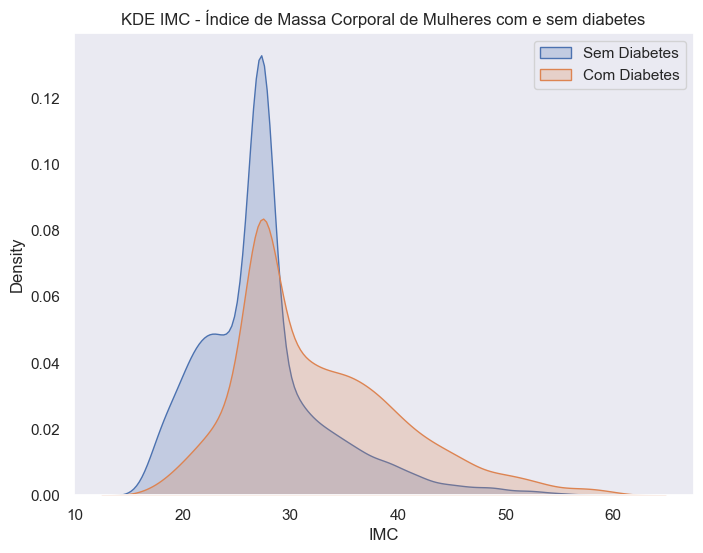

In [92]:
#Gráfico de Densidade de Índice de Massa Corporal de Mulheres com e sem diabetes


plt.figure(figsize=(8,6))
sns.kdeplot(data=DM_filtrado.query('gender == "Female" & diabetes == 0'), x='bmi', shade=True, label='Sem Diabetes')
sns.kdeplot(data=DM_filtrado.query('gender == "Female" & diabetes == 1'), x='bmi', shade=True, label='Com Diabetes')
plt.title('KDE IMC - Índice de Massa Corporal de Mulheres com e sem diabetes')
plt.xlabel('IMC')
plt.legend()
plt.show()

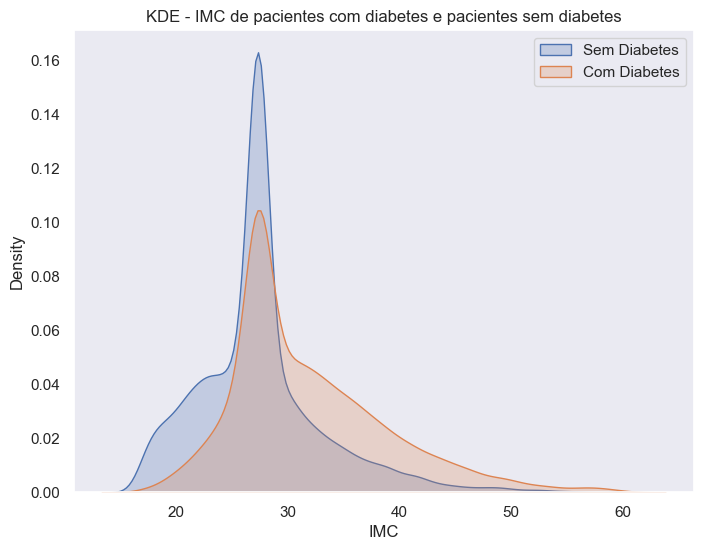

In [93]:
#Gráfico de Densidade de IMC de pacientes com diabetes e pacientes sem diabetes


plt.figure(figsize=(8,6))
sns.kdeplot(data=DM_filtrado.query('diabetes == 0'), x='bmi', shade=True, label='Sem Diabetes')
sns.kdeplot(data=DM_filtrado.query('diabetes == 1'), x='bmi', shade=True, label='Com Diabetes')
plt.title('KDE - IMC de pacientes com diabetes e pacientes sem diabetes')
plt.xlabel('IMC')
plt.legend()
plt.show()

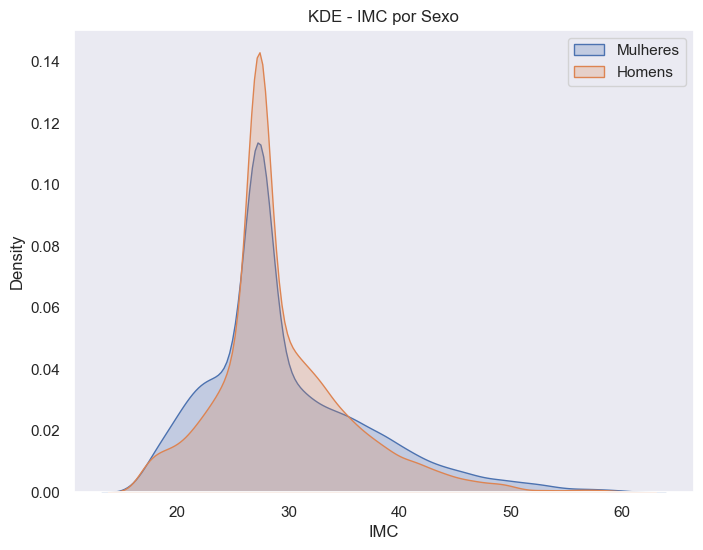

In [94]:
#Gráfico de Densidade de IMC de pacientes com diabetes e pacientes sem diabetes


plt.figure(figsize=(8,6))
sns.kdeplot(data=DM_filtrado.query('gender == "Female"'), x='bmi', shade=True, label='Mulheres')
sns.kdeplot(data=DM_filtrado.query('gender == "Male"'), x='bmi', shade=True, label='Homens')
plt.title('KDE - IMC por Sexo')
plt.xlabel('IMC')
plt.legend()
plt.show()

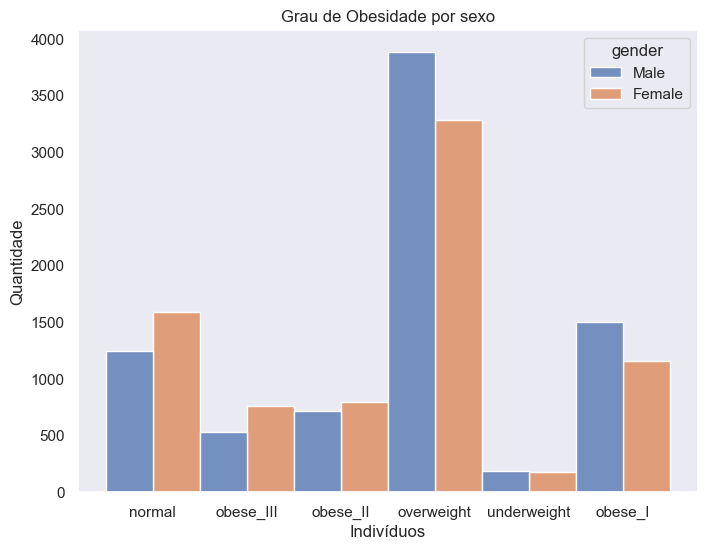

In [95]:
#Gráfico de barras de Grau de Obesidade por sexo

plt.figure(figsize=(8,6))
sns.histplot(data=DM_filtrado, x='grau_obesidade_class', hue='gender', multiple='dodge')
plt.title('Grau de Obesidade por sexo')
plt.ylabel('Quantidade')
plt.xlabel('Indivíduos')
plt.show()

Com essa breve análise estatística descritiva podemos avaliar que o que foi citado como motivo da análise da obesidade encontra verossimilhança nos gráficos, onde há maior concentração de pessoas acometidas com Diabetes Mellitus nos IMC ≥ 30, ou seja pessoas com sobrepeso.

Podemos ver também que mulheres são as que mais aparecem nos dados, mesmo quando igualados em números de amostras.

# Faixa Etária

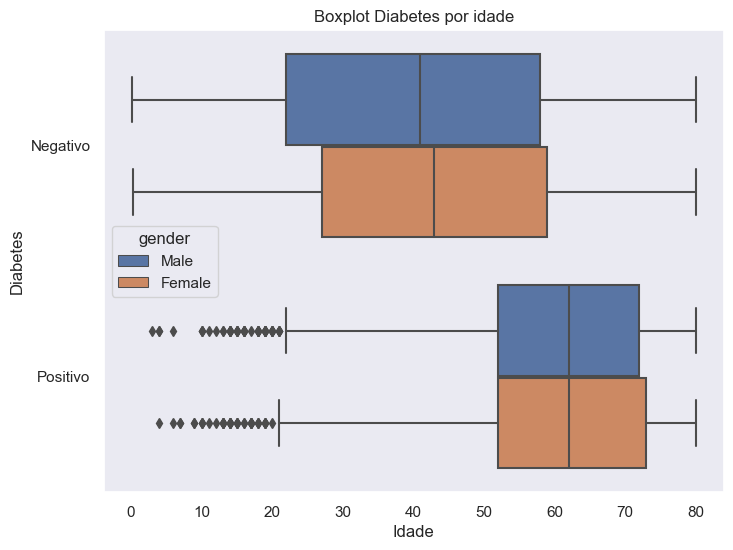

In [96]:
#Gráfico de caixa Hipertensão por Idade

plt.figure(figsize=(8,6))
sns.boxplot(data=DM_filtrado, x='age', y='diabetes', orient='h', hue='gender')
plt.title('Boxplot Diabetes por idade')
plt.ylabel('Diabetes')
plt.xlabel('Idade')
plt.gca().set_yticklabels(['Negativo', 'Positivo'])
plt.show()

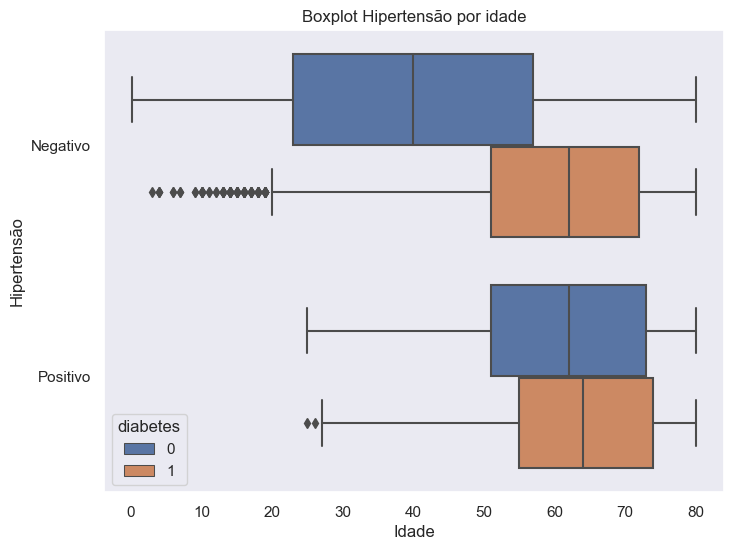

In [97]:
#Gráfico de caixa Hipertensão por Idade

plt.figure(figsize=(8,6))
sns.boxplot(data=DM_filtrado, x='age', y='hypertension', orient='h', hue='diabetes')
plt.title('Boxplot Hipertensão por idade')
plt.ylabel('Hipertensão')
plt.xlabel('Idade')
plt.gca().set_yticklabels(['Negativo', 'Positivo'])
plt.show()

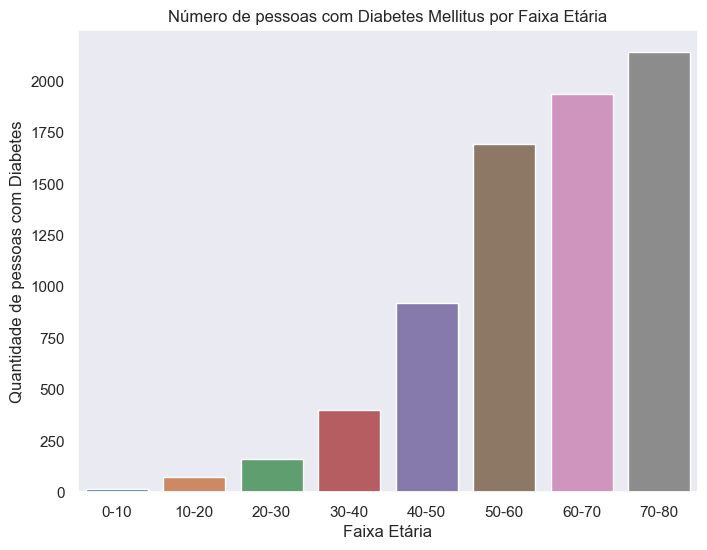

In [98]:
#Criando o DataFrame

faixa = DM_filtrado.groupby(['faixa_etaria', 'diabetes'])[['gender']].count().reset_index()


#Criando Gráfico de Barras de indivíduos com diabetes por faixa etária

plt.figure(figsize=(8,6))
sns.barplot(data=faixa.query('diabetes == 1'), y='gender', x='faixa_etaria')
plt.title('Número de pessoas com Diabetes Mellitus por Faixa Etária')
plt.ylabel('Quantidade de pessoas com Diabetes')
plt.xlabel('Faixa Etária')
plt.show()

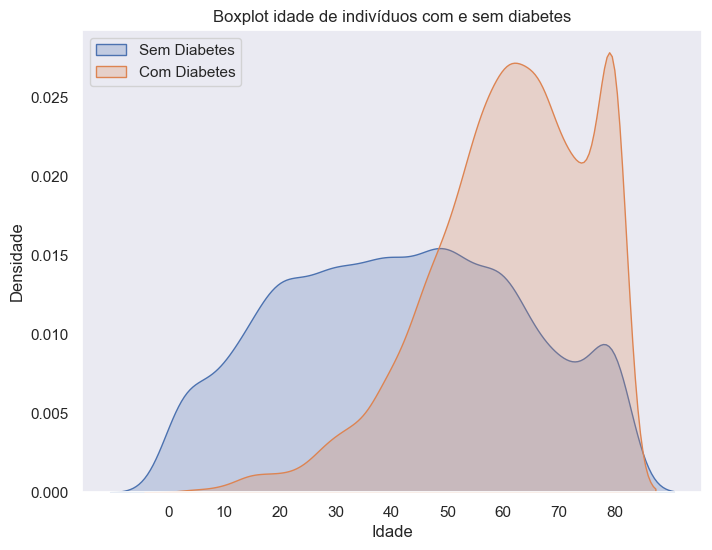

In [99]:
#Gráfico de Densidade de Idade de indivíduos com e sem diabetes

plt.figure(figsize=(8,6))
sns.kdeplot(data=DM_filtrado.query('diabetes == 0'), x='age', shade=True, label='Sem Diabetes')
sns.kdeplot(data=DM_filtrado.query('diabetes == 1'), x='age', shade=True, label='Com Diabetes')
plt.title('Boxplot idade de indivíduos com e sem diabetes')
plt.ylabel('Densidade')
plt.xlabel('Idade')

idades = np.arange(0, DM_df['age'].max() + 1, 10)
plt.xticks(idades)

plt.legend(loc='upper left')
plt.show()

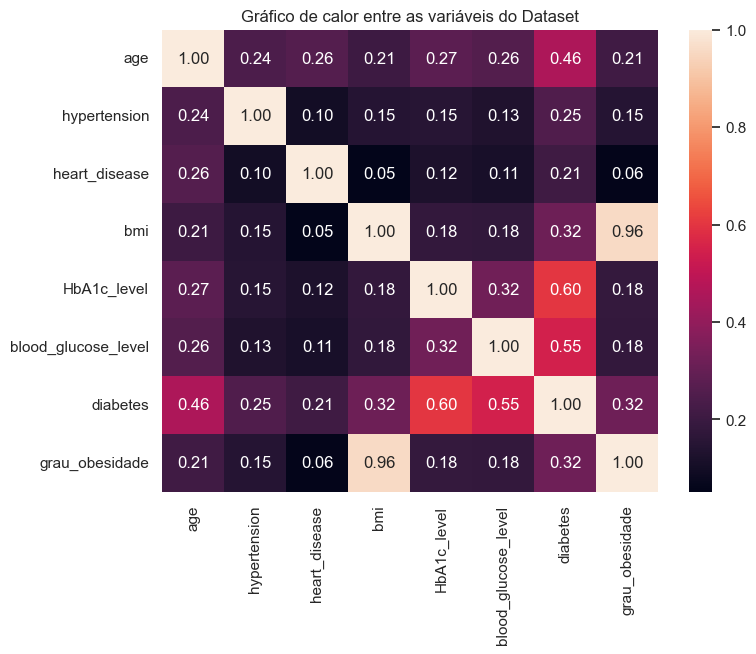

In [100]:
#Gráfico de calor entre as variáveis do Dataset


plt.figure(figsize=(8,6))
sns.heatmap(DM_filtrado.corr()
            ,annot= True
            ,fmt='.2f')
plt.title('Gráfico de calor entre as variáveis do Dataset')
plt.show()

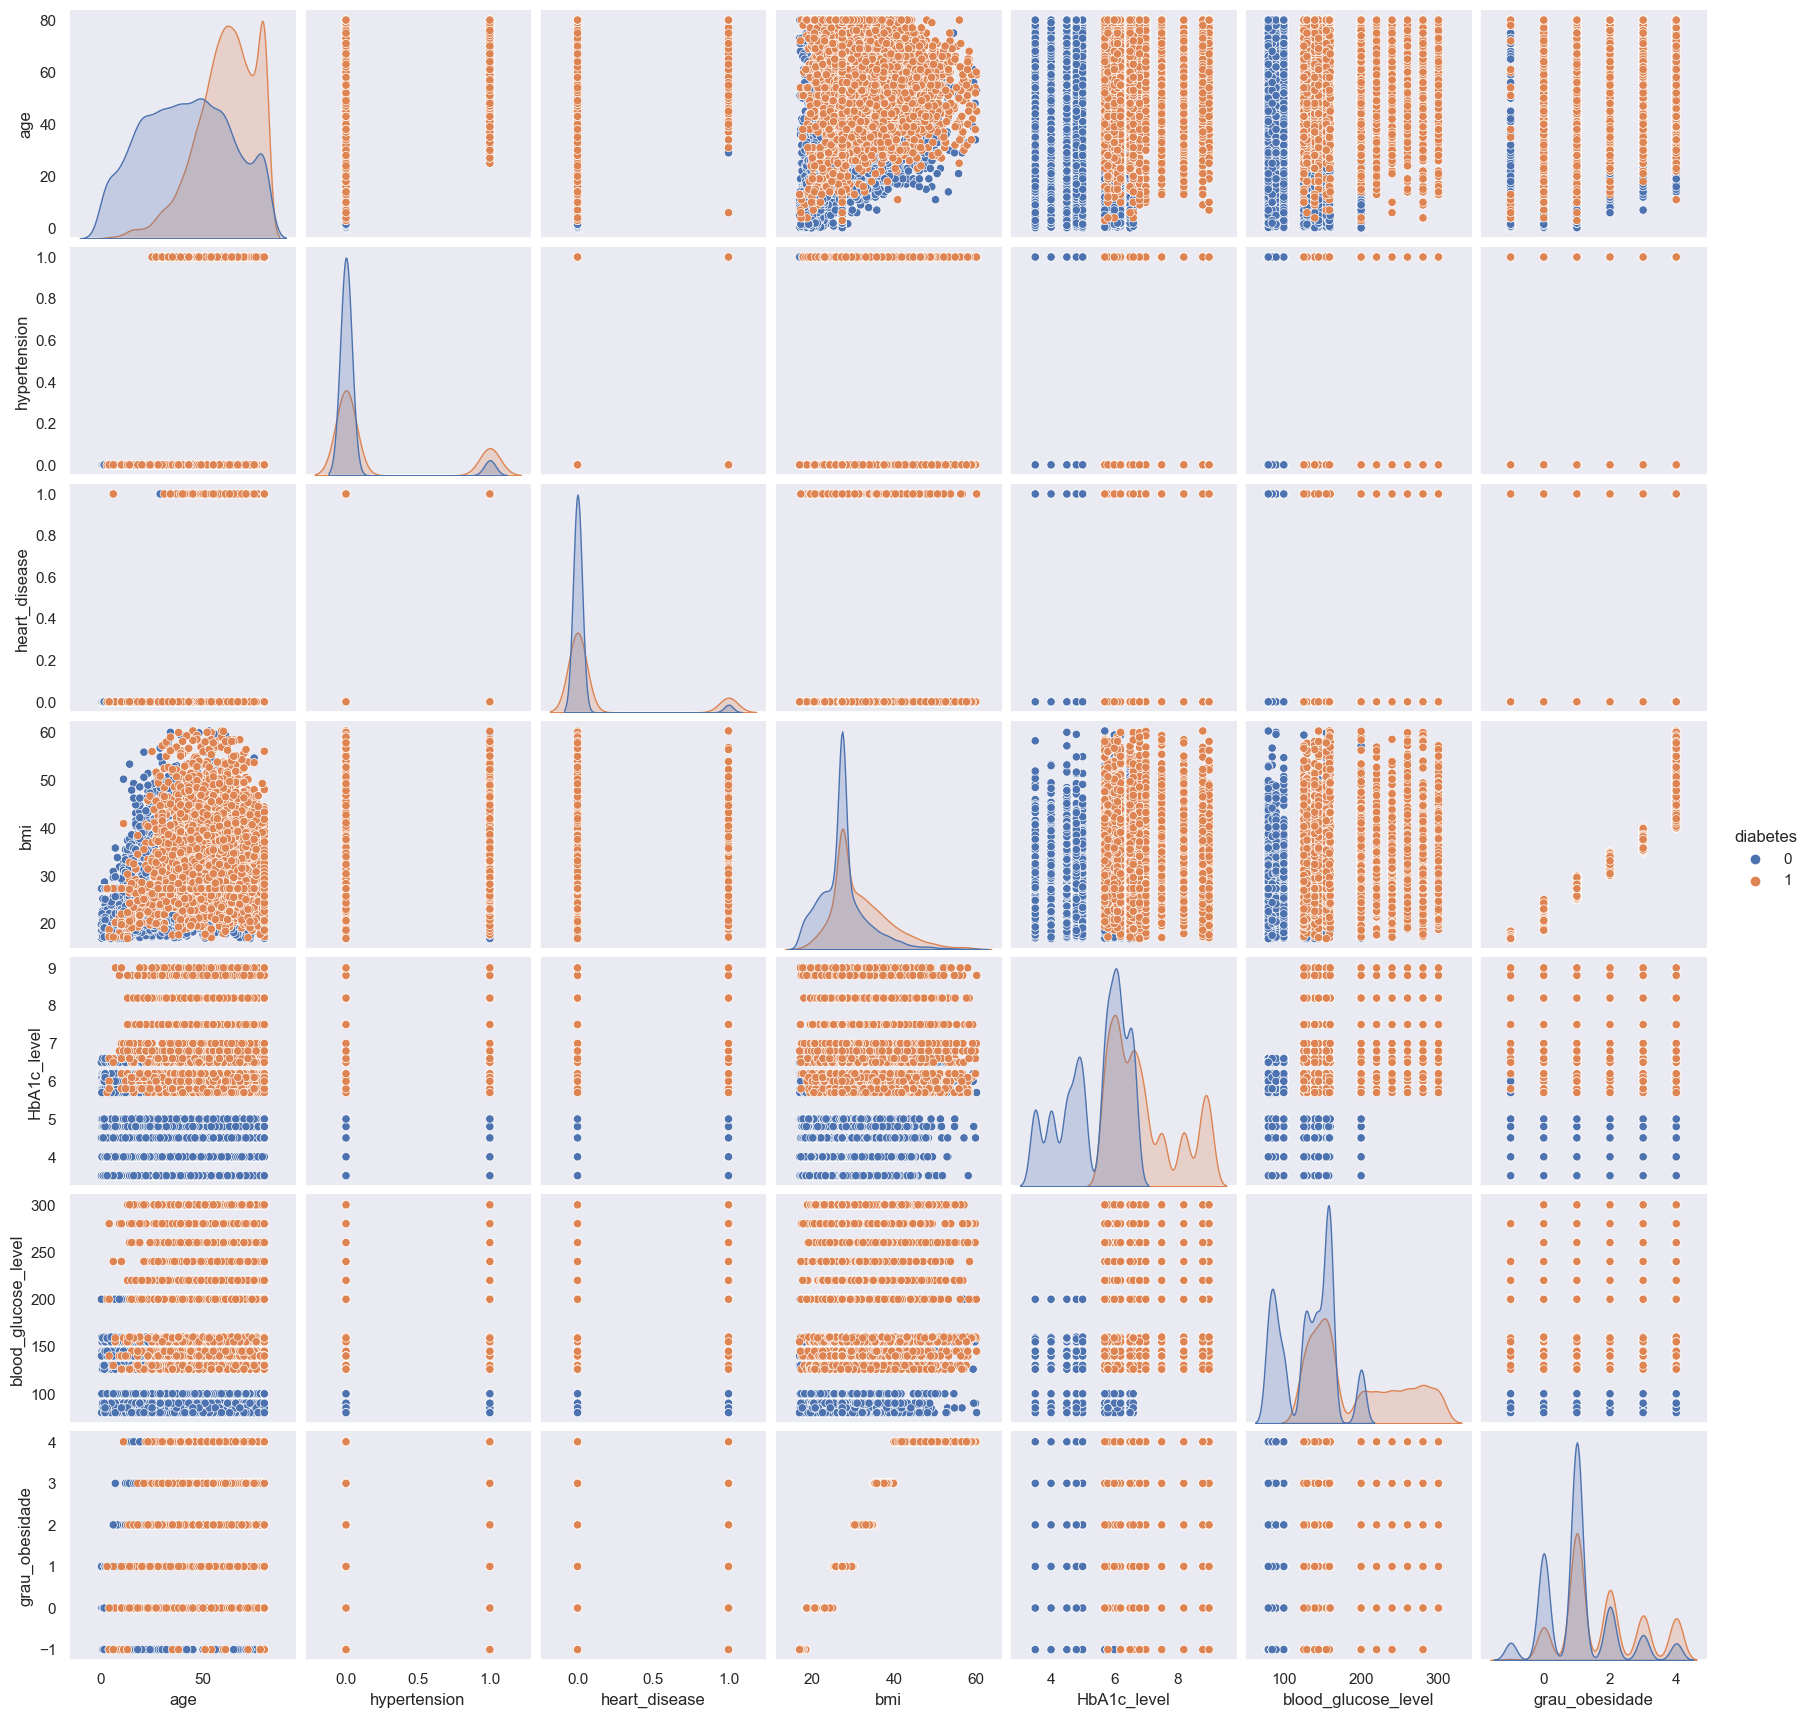

In [101]:
sns.pairplot(data= DM_filtrado, hue='diabetes')
plt.show()

Sobre a matriz de correlação entre as variáveis apresentadas no conjunto de dados analisádos, vemos que:


- age (idade): A idade tem uma correlação positiva de fraca à moderada com várias variáveis, como:

        > incluindo hipertensão (0,24);
        > doença cardíaca (0,26);
        > nível de HbA1c (0,27);
        > nível de glicose no sangue (0,25);
        > diabetes (0,45);
        > e grau de obesidade (0,21). 

Isso sugere que, à medida que a idade aumenta, essas variáveis também tendem a aumentar em certa medida.

- hypertension (hipertensão): A hipertensão tem uma correlação positiva fraca com outras variáveis, como:

        > idade (0,24);
        > doença cardíaca (0,10);
        > nível de HbA1c (0,15);
        > nível de glicose no sangue (0,13);
        > diabetes (0,26);
        > e grau de obesidade (0,15).

- heart_disease (doença cardíaca): A doença cardíaca tem uma correlação positiva fraca com:

        > idade (0,26);
        > e uma correlação muito fraca com as outras variáveis.

- bmi (índice de massa corporal): O BMI tem uma forte correlação positiva com:

        > o grau de obesidade (0,96), o que era esperado, uma vez que o grau de obesidade é calculado com base no BMI(IMC);
        > Também tem uma correlação positiva moderada com idade (0,20);
        > e uma correlação negativa fraca com doença cardíaca (0,05).

- HbA1c_level (nível de HbA1c): O nível de HbA1c tem uma correlação positiva moderada e correlações positivas fracas com:

        > diabetes (0,60);
        > idade (0,27);
        > hipertensão (0,15);
        > e nível de glicose no sangue (0,32).

- blood_glucose_level (nível de glicose no sangue): O nível de glicose no sangue tem uma correlação positiva fraca com:

        > idade (0,25), hipertensão (0,13) nível de HbA1c (0,32);
        > e moderada com diabetes (0,54).

- diabetes: Diabetes tem uma correlação positiva fraca com:

        > idade (0,45) e grau de obesidade (0,32);
        > e moderada com nível de HbA1c (0,60) e nível de glicose no sangue (0,54)

Isso indica que essas variáveis estão relacionadas à presença de diabetes.

- grau_obesidade: O grau de obesidade tem uma forte correlação positiva forte

        > com BMI (0,96), como explicado supra; 
        > e correlações positivas fracas com idade (0,21) e diabetes (0,32).

Esses valores de correlação podem ajudar a entender as relações entre as variáveis no conjunto de dados e identificar quais variáveis têm uma associação mais forte entre si e com a causa da Diabetes Mellitus.

# Diabetes Mellitus no Brasil

![DM no Brasil](img\prevalencia_de_dm.png)
![DM1](img\Ranking.png)

In [102]:
#Calculando a mudança percentual Ano a Ano

POP_df['%']   = POP_df.Valor.pct_change()
POP_df.fillna(0, inplace=True)
POP_df['Ano'] = POP_df['Ano'].apply(lambda x: int(x))
POP_df        = POP_df[POP_df['Ano'] <= 2021]
POP_df

,Nível Territorial,Unidade de Medida,Valor,Variável,Ano,%
0,Brasil,Mil pessoas,197074,População,2012,0.000000
1,Brasil,Mil pessoas,198503,População,2013,0.007251
2,Brasil,Mil pessoas,200217,População,2014,0.008635
3,Brasil,Mil pessoas,202067,População,2015,0.009240
4,Brasil,Mil pessoas,203763,População,2016,0.008393
5,Brasil,Mil pessoas,205305,População,2017,0.007568
6,Brasil,Mil pessoas,206966,População,2018,0.008090
7,Brasil,Mil pessoas,208738,População,2019,0.008562
8,Brasil,Mil pessoas,210210,População,2020,0.007052
9,Brasil,Mil pessoas,211782,População,2021,0.007478


In [103]:
#Calculando a mudança percentual Ano a Ano

DM_OB['%']      = DM_OB.Óbitos.pct_change()
DM_OB.fillna(0, inplace=True)
DM_OB['Ano']    = DM_OB['Ano'].apply(lambda x: int(x))
DM_OB

,Ano,Óbitos,%
0,2012,56761,0.000000
1,2013,58017,0.022128
2,2014,57882,-0.002327
3,2015,59641,0.030389
4,2016,61398,0.029460
5,2017,63486,0.034008
6,2018,65113,0.025628
7,2019,66711,0.024542
8,2020,75712,0.134925
9,2021,78258,0.033627


In [104]:
# Razão de Óbito e População


oxp = (DM_OB['Óbitos']/(POP_df['Valor'] * 1000)) * 100

D_x_P = pd.DataFrame({'Ano': DM_OB['Ano'],
                      '%': oxp})

D_x_P

,Ano,%
0,2012,0.028802
1,2013,0.029227
2,2014,0.028910
3,2015,0.029515
4,2016,0.030132
5,2017,0.030923
6,2018,0.031461
7,2019,0.031959
8,2020,0.036017
9,2021,0.036952


In [105]:
# Calcula o CAGR - Taxa de Crescimento Anual Composta

#CAGR Diabetes
cagr_dm = ((78258 / 56761) ** (1 / 9)) - 1
cagr_percent_dm = cagr_dm * 100

#CAGR População
cagr_pop = ((211782 / 197074) ** (1 / 9)) - 1
cagr_percent_pop = cagr_pop * 100



print(f'O CAGR dos óbitos por diabetes no Brasil de 2012 até 2021 é de: {round(cagr_percent_dm, 2)}%')
print('='*75)
print(f'O CAGR do crescimento da população brasileira de 2012 até 2021 é de: {round(cagr_percent_pop, 2)}%')

O CAGR dos óbitos por diabetes no Brasil de 2012 até 2021 é de: 3.63%
O CAGR do crescimento da população brasileira de 2012 até 2021 é de: 0.8%


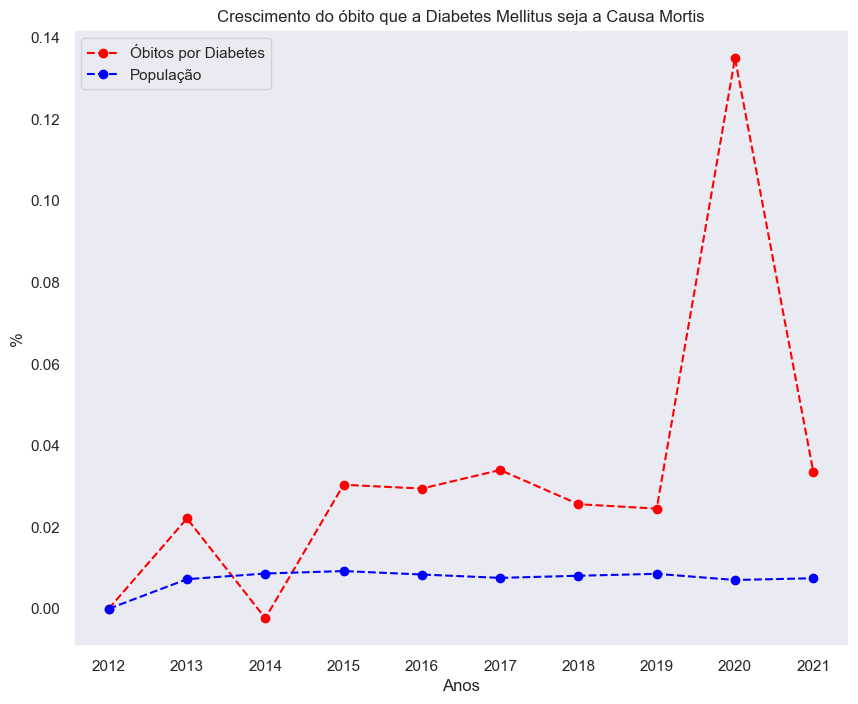

In [106]:
#Gráfico de linha População x Óbitos por Diabetes

plt.figure(figsize=(10,8))

plt.plot(DM_OB['Ano'], DM_OB['%'], 'go--', color='red', label="Óbitos por Diabetes")
plt.plot(POP_df['Ano'], POP_df['%'], 'go--', color='blue', label="População")


plt.title(f'Crescimento do óbito que a Diabetes Mellitus seja a Causa Mortis')
plt.xlabel('Anos')
plt.xticks(DM_OB['Ano'])
plt.ylabel(f'%')
plt.legend()


plt.show()

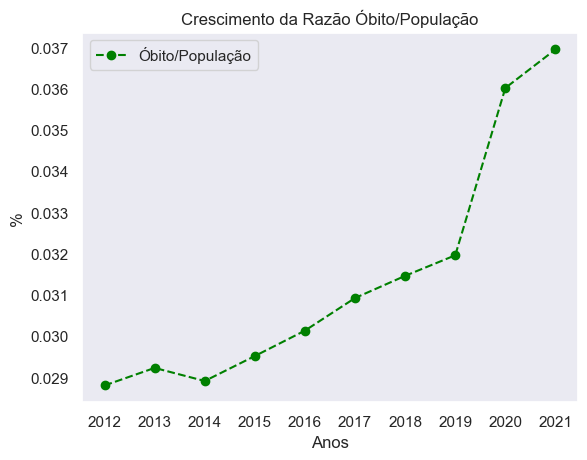

In [107]:
plt.plot(D_x_P['Ano'], D_x_P['%'], 'go--', color='green', label="Óbito/População")
plt.title(f'Crescimento da Razão Óbito/População')
plt.xlabel('Anos')
plt.xticks(D_x_P['Ano'])
plt.ylabel(f'%')
plt.legend()


plt.show()

Analisando o CAGR e os gráficos, vemos que o crescimento dos óbitos causados pela Diabetes é maior que a taxa de crescimento da população e mesmo que os números de óbitos sejam pequenos em relação a população total, como podemos ver. 

A Diabetes é um problema que vem crescendo a cada ano. Pelos valor do CAGR, podemos estimar que o número de óbitos pode crescer cerca de 3,6% nos anos subsequentes aos apresentados nos dados. 



# Impactos da Diabetes na Saúde brasileira (DALYs - Disability-Adjusted Life Years - **Anos de Vida Ajustados por Incapacidade**)


DALYs são uma métrica usada na saúde pública para medir a carga de doenças em uma população. Essa métrica combina informações sobre mortalidade (morte prematura) e morbidade (incapacidade) para avaliar o impacto total de uma doença, lesão ou condição de saúde em uma sociedade.

Segundo o Ipea:

            "Por sua vez, o DALYs expressa a carga da doença, correspondendo à somatória dos anos de vida perdidos por mortalidade precoce (em relação a um padrão mundial) e dos anos vividos em condições de incapacidade ou deficiência, devido a doenças e lesões. O DALYs pode ser expresso em números absolutos ou por 100 mil habitantes, como se faz usualmente com os indicadores tradicionais de mortalidade. Ao ter a pretensão de ser um indicador panorâmico e amplamente abrangente dos problemas de saúde de um país mediante um equivalente geral, que são os anos de vida perdidos ajustados por incapacidade, o DALYs pode ser considerado analogicamente como uma espécie de produto interno bruto negativo da saúde."



![DALYs](img\ranking_cm.png)

In [108]:
#Calculo do CAGR - Taxa de Crescimento Anual Composta

#CAGR DALYs de Diabetes - Brasil
cagr_dm = ((2564212 / 1903709) ** (1 / 11)) - 1
cagr_percent_dm = cagr_dm * 100


print(f'O CAGR dos DALYs do Brasil em virtude da Diabetes de 2009 até 2019 é de: {round(cagr_percent_dm, 2)}%')

O CAGR dos DALYs do Brasil em virtude da Diabetes de 2009 até 2019 é de: 2.74%


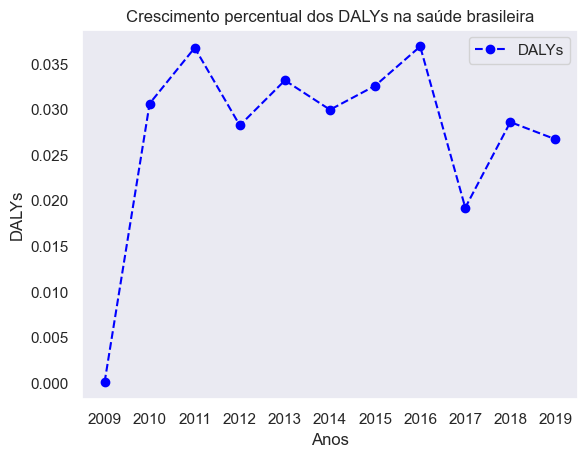

In [109]:
#Gráfico do crescimento percentual dos DALYs na saúde brasileira'


plt.plot(DALYs_numbers.index, DALYs_numbers['%'], 'go--', color='blue', label='DALYs')
plt.title(f'Crescimento percentual dos DALYs na saúde brasileira')
plt.xlabel('Anos')
plt.xticks(DALYs_numbers.index)
plt.ylabel(f'DALYs')
plt.legend()
plt.show()

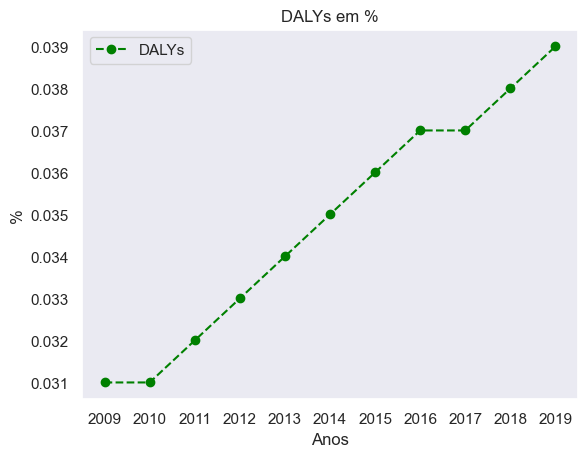

In [110]:
plt.plot(DALYs_percent.index, DALYs_percent.val, 'go--', color='green', label="DALYs")
plt.title(f'DALYs em %')
plt.xlabel('Anos')
plt.xticks(DALYs_percent.index)
plt.ylabel(f'%')
plt.legend()
plt.show()

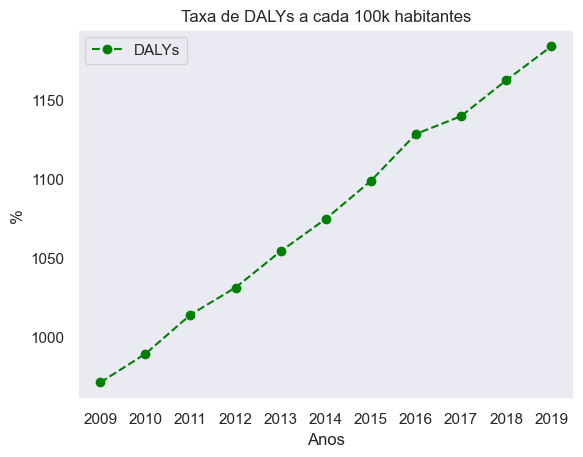

In [111]:
plt.plot(DALYs_rate.index, DALYs_rate.val, 'go--', color='green', label="DALYs")
plt.title(f'Taxa de DALYs a cada 100k habitantes')
plt.xlabel('Anos')
plt.xticks(DALYs_rate.index)
plt.ylabel(f'%')
plt.legend()
plt.show()

Podemos observar que a cada ano a Diabetes Mellitus impacta na saúde do Brasil. Assim como o crescimento de óbitos o DALYs pode manter o crescimento perto da faixa do CAGR, como ainda não temos dados dos anos de 2020 até 2022 tal afirmação ficará no campo da especulação.

# Conclusão


Ante todo o exposto, concluimos que as preocupações das organizações de saúde são válidas, uma vez que, é nítido o crescimento de individuos com diabetes e dos seus fatores de risco, como a obesidade, por exemplo.
É possível também concluir que a doença representa um desafio para a saúde pública do Brasil e do mundo.

Alguns pontos devem ser destacados na presente análise:

* A Diabetes é uma doença que afeta uma parcela da população mundial. E tal doença pode levar a complicações mais graves, como, por exemplo, a amputação de membros.

* A análise ressalta a importância do combate também aos fatores de risco, como a obesidade. A obesidade por si é um fator de risco estabelecido academicamente, por isso as medidas de tratamento da obesita e cuidados com a saúde, programas que incentivem à prática de atividade física podem desempenhar um papel importante na redução de casos de Diabetes tipo 2.

* Vimos também que a diabetes possui um impacto significativo na saúde pública e na expectativa de vida da população como evidênciado pelo aumento de casos de óbitos ao longo dos anos. 

Posto isso, concluímos que a prevenção da Diabetes é fundamental. Conscientizar a população sobre os fatores de risco, promover a adoção de hábitos saudáveis e principalmente a detecção antecipada da doença pode ser muito benéfica a saúde pública doméstica quanto externa.

Cito, Horton, 2012, p.2053:

            "A incapacidade em virtude de doença e lesão vai se tornar um problema cada vez mais impor-
            tante para todos os sistemas de saúde. Mais pessoas vão passar mais anos de suas vidas com mais
            doenças. As mulheres são especialmente afetadas pela incapacidade. Mulheres com idade entre
            5-65 anos perdem mais vida sadia devido à incapacidade do que os homens. No entanto, a inca-
            pacidade foi praticamente ignorada como prioridade política central durante a era dos Objetivos
            de Desenvolvimento do Milênio"

Em resumo, a análise destaca a gravidade da Diabetes como um problema de saúde pública e enfatiza a importância de abordagens multidisciplinares para combater essa doença, incluindo a conscientização da população, a promoção de hábitos saudáveis e a implementação de políticas eficazes. O enfrentamento da Diabetes requer um esforço conjunto de governos, profissionais de saúde e da sociedade como um todo.

A respeito desse último nosso grupo se dispôs  para a criação de algoritmos de ML (Machine Learning), com o intuito de consciêntizar as pessoas sobre os riscos que elas, eventualmente, correm de desenvolver Diabetes tipo 2. Antes de tudo é importante salientar que tal algoritmo não exime o indivíduo de consulta com profissional qualificado, pelo contrário é uma forma de incentivo a busca desse profissional para que faça os exames e receba os tratamentos adequados.


# Bibliografia

Buchwald H, Avidor Y, Branwald E. Bariatric surgery: a systematic review and meta-analysis. JAMA 2004

WAITZBERG, Dan Linetzky. Nutrição oral, enteral e parenteral na prática clínica. . São Paulo: Atheneu. . Acesso em: 22 set. 2023. , 2009

PIMENTA, Gunther Peres et al. Mortality, weight loss and quality of life of patients with morbid obesity: evaluation of the surgical and medical treatment after 2 years. Revista Brasileira de Cirurgia Bariátrica e Metabólica, 2010

CHENTLI, Farida; AZZOUG, Said; MAHGOUN, Souad. Diabetes mellitus in elderly. Indian Journal of Endocrinology and Metabolism, v. 19, n. 7, p. 744, 2015. Publicado por Wolters Kluwer - Medknow.

Global Burden of Disease Collaborative Network. Global Burden of Disease Study 2019 (GBD 2019) Results. Seattle, United States: Institute for Health Metrics and Evaluation (IHME), 2020. Available from https://vizhub.healthdata.
org/gbd-results/.

Schmidt et al.: High prevalence of diabetes and intermediate hyperglycemia - The Brazilian Longitudinal Study of Adult Health (ELSA-Brasil). Diabetology & Metabolic Syndrome 2014 6:

Vos T, Flaxman AD, Naghavi M, Lozano R, Michaud C, Ezzati M, Shibuya K,Salomon JA, Abdalla S, Aboyans V, Abraham J, Ackerman I, Aggarwal R, Ahn SY, Ali MK, Alvarado M, Anderson HR, Anderson LM, Andrews KG, Atkinson C, Baddour LM, Bahalim AN, Barker-Collo S, Barrero LH, Bartels DH, Basáñez M-G, Baxter A, Bell ML, Benjamin EJ, Bennett D, et al: Years lived with disability (YLDs) for 1160 sequelae of 289 diseases and injuries 1990-2010: a systematic analysis for the Global Burden of Disease Study 2010. Lancet 2012, 380:2163–2196

Dritsas, E.; Trigka, M. Data-Driven Machine-Learning Methods for Diabetes Risk Prediction. Sensors 2022, 22, 5304. https://doi.org/10.3390/s22145304

Chatterjee, S.; Khunti, K.; Davies, M.J. Type 2 diabetes. Lancet 2017, 389, 2239–2251.